In [1]:

import pandas as pd
import numpy as np
import pickle
import math

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import scipy.fftpack as fftpack
from scipy.stats import binned_statistic

import argparse
import glob
from datetime import datetime

import F21DataLoader as dl


R2 Score: [0.48000000000000076, 0.695]
se raw: [[0.0004 0.0625]
 [0.0004 0.09  ]
 [0.01   0.0625]
 [0.01   0.09  ]]
se weighted: [0.0029 0.004  0.0125 0.0136]
actual_xHI  actual_logfX
0.6         -1.0            0.01305
0.8          0.0            0.00345
Name: agg_rmse, dtype: float64
   actual_xHI  actual_logfX  pred_xHI  pred_logfX      se  agg_rmse
0         0.8           0.0      0.82       -0.25  0.0029   0.00345
1         0.8           0.0      0.82        0.30  0.0040   0.00345
2         0.6          -1.0      0.70       -1.25  0.0125   0.01305
3         0.6          -1.0      0.50       -0.70  0.0136   0.01305
   actual_xHI  actual_logfX  pred_xHI  pred_logfX      se  agg_rmse
0         0.8           0.0      0.82       -0.25  0.0029  0.058737
1         0.8           0.0      0.82        0.30  0.0040  0.058737
2         0.6          -1.0      0.70       -1.25  0.0125  0.114237
3         0.6          -1.0      0.50       -0.70  0.0136  0.114237


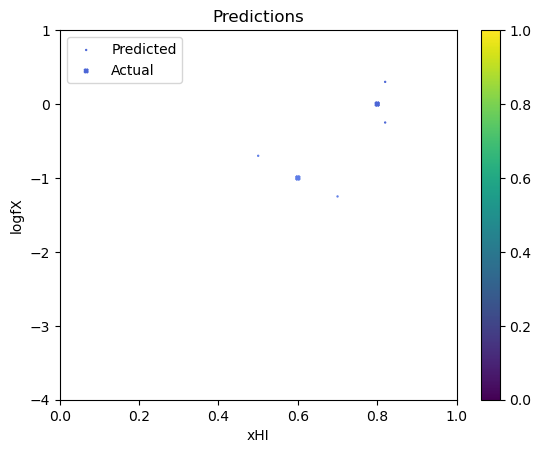

In [20]:
def summarize_test(y_pred, y_test):
    # Calculate R2 scores
    r2 = [r2_score(y_test[:, i], y_pred[:, i]) for i in range(2)]
    print("R2 Score: " + str(r2))

    # Calculate rmse scores
    se = (y_test - y_pred) ** 2
    print(f"se raw: {se}")
    se[:,1] /= 25 
    se_combined = se[:,0] + se[:,1]
    print(f"se weighted: {se_combined}")
    df_y = pd.DataFrame()
    df_y = df_y.assign(actual_xHI=y_test[:,0])
    df_y = df_y.assign(actual_logfX=y_test[:,1])
    df_y = df_y.assign(pred_xHI=y_pred[:,0])
    df_y = df_y.assign(pred_logfX=y_pred[:,1])
    df_y = df_y.assign(se=se_combined)
    df_y_agg = df_y.groupby(["actual_xHI", "actual_logfX"])['se'].mean()
    df_y_agg.rename('agg_rmse', inplace=True)
    print(df_y_agg)
    df_y = df_y.merge(df_y_agg, on=['actual_xHI', 'actual_logfX'], validate='many_to_one')
    print(df_y)
    df_y=df_y.assign(agg_rmse=np.sqrt(df_y['agg_rmse']))
    print(df_y)
    #rms_scores_percent = np.array([mse[:, i]*100/np.abs(np.mean(y_test[:, i])) for i in range(2)])
    #print("RMS Error: " + str(rms_scores_percent))
    cmap = plt.get_cmap('viridis')
    rmse = df_y['agg_rmse']
    norm = plt.Normalize(rmse.min(), rmse.max())
    colors = cmap(norm(rmse))

    plt.scatter(df_y['pred_xHI'], df_y['pred_logfX'], marker=".", s=2, label='Predicted', c=colors)
    plt.scatter(df_y['actual_xHI'], df_y['actual_logfX'], marker="X", s=8, label='Actual', c=colors)
    plt.xlim(0, 1)
    plt.ylim(-4, 1)
    plt.xlabel('xHI')
    plt.ylabel('logfX')
    plt.title('Predictions')
    plt.legend()
    plt.colorbar()
    plt.savefig('output/f21_prediction.png')
    plt.show()

summarize_test(np.array([
    [0.82, -0.25], 
    [0.82, 0.3], 
    [0.7, -1.25], 
    [0.5, -0.7]]), 
    np.array([
        [0.8, 0.0], 
        [0.8, 0.0], 
        [0.6, -1.0], 
        [0.6, -1.0]]))